# Phase 3b: Generate Dataset 2 - Augmented with Synthetic Cuts

This notebook generates fragments by **augmenting domain annotations with synthetic cut points**.

**Strategy**: 
- Start with proteins that have domain annotations
- Add synthetic cut points at N-terminus and/or C-terminus where natural domains are missing
- This particularly helps create more `terminal_both` fragments
- Combine natural domain cuts with synthetic cuts

**Augmentation Rules**:
- If protein has C-terminal domain but no N-terminal domain → add synthetic N-terminal cut
- If protein has N-terminal domain but no C-terminal domain → add synthetic C-terminal cut
- If protein has internal domains only → add both synthetic terminal cuts
- Synthetic cuts are placed at reasonable positions (e.g., 10-30% from terminus)

**Output**: 
- CSV with same structure as Dataset 1
- Mix of domain-based and synthetic fragments
- Labeled to indicate if cut was synthetic or domain-based

In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 1. Load Data and Target Distribution

In [2]:
# Load processed proteins
print("Loading processed protein data...")
df_proteins = pd.read_csv('swissprot_proteins_processed.csv')
df_proteins['domains'] = df_proteins['domains'].apply(json.loads)
df_with_domains = df_proteins[df_proteins['n_domains'] > 0].copy()

print(f"Proteins with domains: {len(df_with_domains):,}")

# Load target distribution from Phase 1
try:
    target_dist = pd.read_csv('fragment_distribution_summary.csv')
    print("\nTarget distribution loaded:")
    print(target_dist[['Fragment Type', 'Percentage']].to_string(index=False))
except:
    print("\nWarning: Could not load target distribution. Using default.")
    target_dist = None

Loading processed protein data...
Proteins with domains: 132,383

Target distribution loaded:
       Fragment Type  Percentage
          terminal_C   29.094828
          terminal_N   28.825431
       terminal_both   25.075431
               mixed   15.754310
        internal_gap    1.239224
terminal_unannotated    0.010776


## 2. Synthetic Cut Point Generation

In [3]:
def generate_synthetic_n_terminal_cut(seq_length, existing_domains):
    """
    Generate a synthetic N-terminal cut point.
    Returns the end position of a synthetic N-terminal domain.
    """
    # Place cut at 10-30% of sequence length
    min_cut = max(10, int(seq_length * 0.10))
    max_cut = min(seq_length // 2, int(seq_length * 0.30))
    
    # Avoid overlap with existing domains
    cut_point = np.random.randint(min_cut, max_cut + 1)
    
    # Check for conflicts with existing domains
    for domain in existing_domains:
        if domain['start'] <= cut_point <= domain['end']:
            # Adjust to be before this domain
            cut_point = min(cut_point, domain['start'] - 1)
    
    return max(10, cut_point)  # Ensure minimum fragment size


def generate_synthetic_c_terminal_cut(seq_length, existing_domains):
    """
    Generate a synthetic C-terminal cut point.
    Returns the start position of a synthetic C-terminal domain.
    """
    # Place cut at 70-90% of sequence length
    min_cut = max(seq_length // 2, int(seq_length * 0.70))
    max_cut = min(seq_length - 10, int(seq_length * 0.90))
    
    cut_point = np.random.randint(min_cut, max_cut + 1)
    
    # Check for conflicts with existing domains
    for domain in existing_domains:
        if domain['start'] <= cut_point <= domain['end']:
            # Adjust to be after this domain
            cut_point = max(cut_point, domain['end'] + 1)
    
    return min(seq_length - 10, cut_point)  # Ensure minimum fragment size


def augment_domains(domains, seq_length):
    """
    Augment domain list with synthetic domains.
    Returns (augmented_domains, has_synthetic_n, has_synthetic_c)
    """
    augmented = domains.copy()
    
    # Check what's missing
    has_n_terminal = any(d['start'] == 1 for d in domains)
    has_c_terminal = any(d['end'] == seq_length for d in domains)
    
    synthetic_n = False
    synthetic_c = False
    
    # Add synthetic N-terminal domain if missing
    if not has_n_terminal:
        cut_end = generate_synthetic_n_terminal_cut(seq_length, domains)
        augmented.append({
            'start': 1,
            'end': cut_end,
            'description': 'SYNTHETIC_N_TERMINAL',
            'synthetic': True
        })
        synthetic_n = True
    
    # Add synthetic C-terminal domain if missing
    if not has_c_terminal:
        cut_start = generate_synthetic_c_terminal_cut(seq_length, domains)
        augmented.append({
            'start': cut_start,
            'end': seq_length,
            'description': 'SYNTHETIC_C_TERMINAL',
            'synthetic': True
        })
        synthetic_c = True
    
    # Sort by start position
    augmented = sorted(augmented, key=lambda x: x['start'])
    
    return augmented, synthetic_n, synthetic_c

## 3. Fragment Generation Functions (Same as Dataset 1)

In [4]:
# Reuse functions from Dataset 1
def generate_terminal_n_fragments(acc_id, sequence, domains):
    fragments = []
    seq_length = len(sequence)
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    
    for domain in n_terminal_domains:
        fragment_seq = sequence[domain['end']:]
        if len(fragment_seq) >= 10:
            is_synthetic = domain.get('synthetic', False)
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'terminal_N',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"1-{domain['end']}",
                'is_synthetic': is_synthetic
            })
    return fragments

def generate_terminal_c_fragments(acc_id, sequence, domains):
    fragments = []
    seq_length = len(sequence)
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    
    for domain in c_terminal_domains:
        fragment_seq = sequence[:domain['start']-1]
        if len(fragment_seq) >= 10:
            is_synthetic = domain.get('synthetic', False)
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'terminal_C',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"{domain['start']}-{seq_length}",
                'is_synthetic': is_synthetic
            })
    return fragments

def generate_terminal_both_fragments(acc_id, sequence, domains):
    fragments = []
    seq_length = len(sequence)
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    
    for n_dom in n_terminal_domains:
        for c_dom in c_terminal_domains:
            if n_dom['end'] < c_dom['start']:
                fragment_seq = sequence[n_dom['end']:c_dom['start']-1]
                if len(fragment_seq) >= 10:
                    is_synthetic = n_dom.get('synthetic', False) or c_dom.get('synthetic', False)
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'terminal_both',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"1-{n_dom['end']},{c_dom['start']}-{seq_length}",
                        'is_synthetic': is_synthetic
                    })
    return fragments

def generate_internal_gap_fragments(acc_id, sequence, domains):
    fragments = []
    seq_length = len(sequence)
    internal_domains = [d for d in domains if d['start'] > 1 and d['end'] < seq_length]
    
    for domain in internal_domains:
        before = sequence[:domain['start']-1]
        after = sequence[domain['end']:]
        fragment_seq = before + after
        if len(fragment_seq) >= 10:
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'internal_gap',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"{domain['start']}-{domain['end']}",
                'is_synthetic': False  # Internal domains are always real
            })
    return fragments

def generate_mixed_fragments(acc_id, sequence, domains):
    fragments = []
    seq_length = len(sequence)
    
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    internal_domains = [d for d in domains if d['start'] > 1 and d['end'] < seq_length]
    
    # N-terminal + internal
    for n_dom in n_terminal_domains:
        for int_dom in internal_domains:
            if n_dom['end'] < int_dom['start']:
                middle = sequence[n_dom['end']:int_dom['start']-1]
                after = sequence[int_dom['end']:]
                fragment_seq = middle + after
                if len(fragment_seq) >= 10:
                    is_synthetic = n_dom.get('synthetic', False)
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'mixed',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"1-{n_dom['end']},{int_dom['start']}-{int_dom['end']}",
                        'is_synthetic': is_synthetic
                    })
    
    # C-terminal + internal
    for c_dom in c_terminal_domains:
        for int_dom in internal_domains:
            if int_dom['end'] < c_dom['start']:
                before = sequence[:int_dom['start']-1]
                middle = sequence[int_dom['end']:c_dom['start']-1]
                fragment_seq = before + middle
                if len(fragment_seq) >= 10:
                    is_synthetic = c_dom.get('synthetic', False)
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'mixed',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"{int_dom['start']}-{int_dom['end']},{c_dom['start']}-{seq_length}",
                        'is_synthetic': is_synthetic
                    })
    
    # All three
    for n_dom in n_terminal_domains:
        for c_dom in c_terminal_domains:
            for int_dom in internal_domains:
                if n_dom['end'] < int_dom['start'] < int_dom['end'] < c_dom['start']:
                    part1 = sequence[n_dom['end']:int_dom['start']-1]
                    part2 = sequence[int_dom['end']:c_dom['start']-1]
                    fragment_seq = part1 + part2
                    if len(fragment_seq) >= 10:
                        is_synthetic = n_dom.get('synthetic', False) or c_dom.get('synthetic', False)
                        fragments.append({
                            'source_accession': acc_id,
                            'fragment_type': 'mixed',
                            'sequence': fragment_seq,
                            'is_fragment': 1,
                            'removed_region': f"1-{n_dom['end']},{int_dom['start']}-{int_dom['end']},{c_dom['start']}-{seq_length}",
                            'is_synthetic': is_synthetic
                        })
    return fragments

def generate_all_fragments_augmented(acc_id, sequence, domains):
    fragments = []
    fragments.extend(generate_terminal_n_fragments(acc_id, sequence, domains))
    fragments.extend(generate_terminal_c_fragments(acc_id, sequence, domains))
    fragments.extend(generate_terminal_both_fragments(acc_id, sequence, domains))
    fragments.extend(generate_internal_gap_fragments(acc_id, sequence, domains))
    fragments.extend(generate_mixed_fragments(acc_id, sequence, domains))
    return fragments

## 4. Generate Augmented Dataset

In [5]:
all_fragments = []
complete_sequences = []
augmentation_stats = {'synthetic_n': 0, 'synthetic_c': 0, 'both_synthetic': 0, 'no_synthetic': 0}

print("Generating augmented fragments...")
print(f"Processing {len(df_with_domains):,} proteins...\n")

for idx, row in tqdm(df_with_domains.iterrows(), total=len(df_with_domains), desc="Generating"):
    acc_id = row['acc_id']
    sequence = row['sequence']
    domains = row['domains']
    seq_length = len(sequence)
    
    # Augment domains with synthetic cuts
    augmented_domains, has_syn_n, has_syn_c = augment_domains(domains, seq_length)
    
    # Track augmentation statistics
    if has_syn_n and has_syn_c:
        augmentation_stats['both_synthetic'] += 1
    elif has_syn_n:
        augmentation_stats['synthetic_n'] += 1
    elif has_syn_c:
        augmentation_stats['synthetic_c'] += 1
    else:
        augmentation_stats['no_synthetic'] += 1
    
    # Generate fragments with augmented domains
    fragments = generate_all_fragments_augmented(acc_id, sequence, augmented_domains)
    all_fragments.extend(fragments)
    
    # Add complete sequences
    for _ in fragments:
        complete_sequences.append({
            'source_accession': acc_id,
            'fragment_type': 'complete',
            'sequence': sequence,
            'is_fragment': 0,
            'removed_region': '',
            'is_synthetic': False
        })

print(f"\n✓ Generated {len(all_fragments):,} fragments")
print(f"✓ Paired with {len(complete_sequences):,} complete sequences")
print(f"\nAugmentation Statistics:")
print(f"  Proteins with synthetic N-terminal cut only: {augmentation_stats['synthetic_n']:,}")
print(f"  Proteins with synthetic C-terminal cut only: {augmentation_stats['synthetic_c']:,}")
print(f"  Proteins with both synthetic cuts: {augmentation_stats['both_synthetic']:,}")
print(f"  Proteins with no synthetic cuts: {augmentation_stats['no_synthetic']:,}")

Generating augmented fragments...
Processing 132,383 proteins...



Generating: 100%|██████████| 132383/132383 [00:03<00:00, 35205.87it/s]


✓ Generated 987,579 fragments
✓ Paired with 987,579 complete sequences

Augmentation Statistics:
  Proteins with synthetic N-terminal cut only: 16,185
  Proteins with synthetic C-terminal cut only: 7,429
  Proteins with both synthetic cuts: 106,192
  Proteins with no synthetic cuts: 2,577


## 5. Create Dataset DataFrame

In [6]:
dataset2 = pd.DataFrame(all_fragments + complete_sequences)
dataset2['sequence_length'] = dataset2['sequence'].str.len()

print(f"Dataset 2 Statistics:")
print("="*60)
print(f"Total sequences: {len(dataset2):,}")
print(f"  Fragments: {len(all_fragments):,}")
print(f"  Complete: {len(complete_sequences):,}")
print(f"\nFragments with synthetic cuts: {dataset2['is_synthetic'].sum():,}")
print(f"Fragments with domain-based cuts: {(dataset2['is_synthetic'] == False).sum() - len(complete_sequences):,}")
print("\nFragment type distribution:")
print(dataset2['fragment_type'].value_counts())

dataset2.head(10)

Dataset 2 Statistics:
Total sequences: 1,975,158
  Fragments: 987,579
  Complete: 987,579

Fragments with synthetic cuts: 764,735
Fragments with domain-based cuts: 222,844

Fragment type distribution:
fragment_type
complete         987579
mixed            420981
internal_gap     187186
terminal_N       129227
terminal_C       127600
terminal_both    122585
Name: count, dtype: int64


,source_accession,fragment_type,sequence,is_fragment,removed_region,is_synthetic,sequence_length
0,A0A009IHW8,terminal_N,KLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIK...,1,1-64,True,205
1,A0A009IHW8,terminal_C,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,1,259-269,True,258
2,A0A009IHW8,terminal_both,KLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIK...,1,"1-64,259-269",True,194
3,A0A009IHW8,internal_gap,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,1,133-266,False,135
4,A0A009IHW8,mixed,KLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIK...,1,"1-64,133-266",True,71
5,A0A023I7E1,terminal_N,DDLFVPVSNFDPKSIFPEIKHPFEPMYANTENGKIVPTNSWISNLF...,1,1-30,True,766
6,A0A023I7E1,terminal_C,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,1,760-796,True,759
7,A0A023I7E1,terminal_both,DDLFVPVSNFDPKSIFPEIKHPFEPMYANTENGKIVPTNSWISNLF...,1,"1-30,760-796",True,729
8,A0A023I7E1,internal_gap,MRFQVIVAAATITMITSYIPGVASQSTSDGSTRRPSLPSSGDDDKH...,1,31-759,False,67
9,A0A023I7E1,mixed,STRRPSLPSSGDDDKHEDGFLLRFRRLNPFNLKHRIY,1,"1-30,31-759",True,37


## 6. Compare with Dataset 1

In [7]:
# Load Dataset 1 for comparison
try:
    dataset1 = pd.read_csv('dataset1_maximum_fragments.csv')
    
    print("Comparison: Dataset 1 vs Dataset 2")
    print("="*80)
    
    comparison = pd.DataFrame({
        'Fragment Type': dataset2['fragment_type'].value_counts().index,
        'Dataset 1': [dataset1[dataset1['fragment_type'] == ft].shape[0] 
                     for ft in dataset2['fragment_type'].value_counts().index],
        'Dataset 2': dataset2['fragment_type'].value_counts().values,
        'Increase': [dataset2[dataset2['fragment_type'] == ft].shape[0] - 
                    dataset1[dataset1['fragment_type'] == ft].shape[0]
                    for ft in dataset2['fragment_type'].value_counts().index]
    })
    comparison['% Increase'] = (comparison['Increase'] / comparison['Dataset 1'] * 100).round(2)
    print(comparison.to_string(index=False))
except:
    print("Could not load Dataset 1 for comparison")

Comparison: Dataset 1 vs Dataset 2
Fragment Type  Dataset 1  Dataset 2  Increase  % Increase
     complete     222844     987579    764735      343.17
        mixed      14352     420981    406629     2833.26
 internal_gap     187186     187186         0        0.00
   terminal_N       6850     129227    122377     1786.53
   terminal_C      13979     127600    113621      812.80
terminal_both        477     122585    122108    25599.16


## 7. Visualization

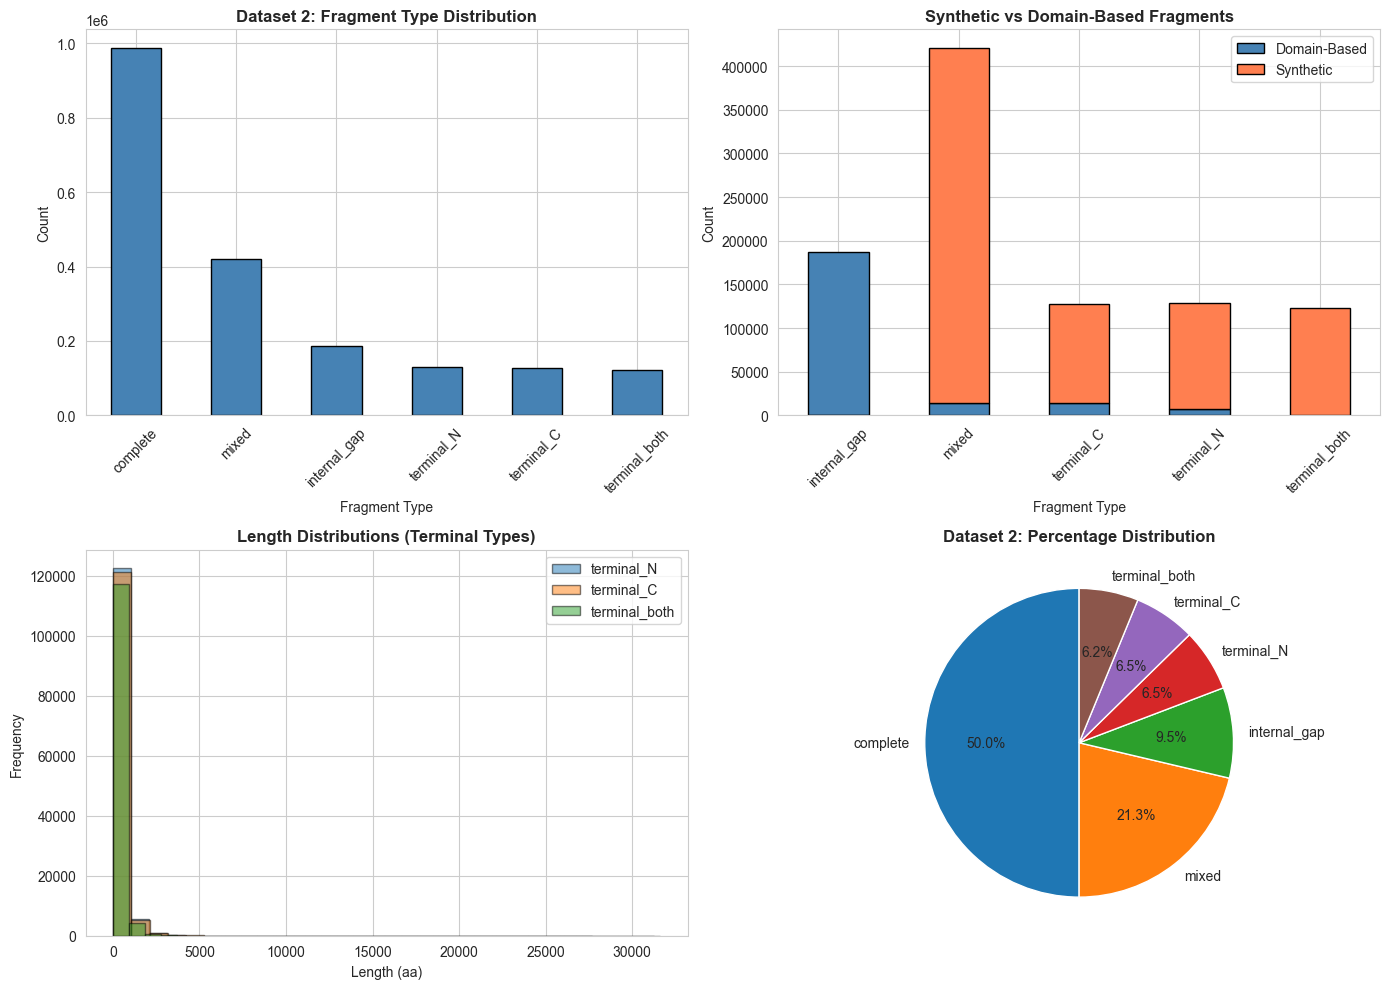

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fragment type distribution
fragment_counts = dataset2['fragment_type'].value_counts()
fragment_counts.plot(kind='bar', ax=axes[0,0], color='steelblue', edgecolor='black')
axes[0,0].set_title('Dataset 2: Fragment Type Distribution', fontweight='bold')
axes[0,0].set_xlabel('Fragment Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Synthetic vs domain-based
fragments_only = dataset2[dataset2['is_fragment'] == 1]
synthetic_counts = fragments_only.groupby(['fragment_type', 'is_synthetic']).size().unstack(fill_value=0)
synthetic_counts.plot(kind='bar', stacked=True, ax=axes[0,1], 
                     color=['steelblue', 'coral'], edgecolor='black')
axes[0,1].set_title('Synthetic vs Domain-Based Fragments', fontweight='bold')
axes[0,1].set_xlabel('Fragment Type')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(['Domain-Based', 'Synthetic'], loc='upper right')
axes[0,1].tick_params(axis='x', rotation=45)

# Length distribution comparison
for ftype in ['terminal_N', 'terminal_C', 'terminal_both']:
    data = dataset2[dataset2['fragment_type'] == ftype]['sequence_length']
    axes[1,0].hist(data, bins=30, alpha=0.5, label=ftype, edgecolor='black')
axes[1,0].set_title('Length Distributions (Terminal Types)', fontweight='bold')
axes[1,0].set_xlabel('Length (aa)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Pie chart
fragment_pct = dataset2['fragment_type'].value_counts(normalize=True) * 100
axes[1,1].pie(fragment_pct, labels=fragment_pct.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Dataset 2: Percentage Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('dataset2_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Length Distribution Comparison with Original Fragments

In [9]:
# Load original fragment data for comparison
try:
    clean_data = pd.read_csv('clean_data.csv')
    clean_data = clean_data[clean_data['fragment_type'] != 'terminal_unannotated']
    clean_data['length'] = clean_data['sequence'].str.len()
    
    # Calculate length statistics by fragment type for original data
    original_stats = {}
    for ftype in ['terminal_N', 'terminal_C', 'terminal_both', 'internal_gap', 'mixed']:
        if ftype in clean_data['fragment_type'].values:
            lengths = clean_data[clean_data['fragment_type'] == ftype]['length']
            original_stats[ftype] = {
                'mean': lengths.mean(),
                'std': lengths.std(),
                'median': lengths.median(),
                'min': lengths.min(),
                'max': lengths.max(),
                'values': lengths.values
            }
    
    print("Original Fragment Length Statistics:")
    print("="*70)
    for ftype, stats in original_stats.items():
        print(f"{ftype:20s}: μ={stats['mean']:>7.1f}, σ={stats['std']:>6.1f}, "
              f"median={stats['median']:>6.1f}, range=[{stats['min']:>4.0f}, {stats['max']:>4.0f}]")
    
    # Calculate length statistics for generated fragments (Dataset 2)
    fragments_only = dataset2[dataset2['is_fragment'] == 1]
    generated_stats = {}
    for ftype in ['terminal_N', 'terminal_C', 'terminal_both', 'internal_gap', 'mixed']:
        if ftype in fragments_only['fragment_type'].values:
            lengths = fragments_only[fragments_only['fragment_type'] == ftype]['sequence_length']
            generated_stats[ftype] = {
                'mean': lengths.mean(),
                'std': lengths.std(),
                'median': lengths.median(),
                'min': lengths.min(),
                'max': lengths.max(),
                'values': lengths.values
            }
    
    print("\nDataset 2 Generated Fragment Length Statistics:")
    print("="*70)
    for ftype, stats in generated_stats.items():
        print(f"{ftype:20s}: μ={stats['mean']:>7.1f}, σ={stats['std']:>6.1f}, "
              f"median={stats['median']:>6.1f}, range=[{stats['min']:>4.0f}, {stats['max']:>4.0f}]")
    
    has_original_data = True
except Exception as e:
    print(f"Warning: Could not load clean_data.csv: {e}")
    print("Skipping comparison with original fragments")
    has_original_data = False

Original Fragment Length Statistics:
terminal_N          : μ=  282.9, σ= 287.8, median= 226.0, range=[   7, 5120]
terminal_C          : μ=  122.7, σ= 227.8, median=  33.0, range=[   4, 3470]
terminal_both       : μ=  194.5, σ= 264.6, median= 128.0, range=[   4, 7311]
internal_gap        : μ=  329.7, σ= 440.2, median= 158.0, range=[  13, 2738]
mixed               : μ=  153.1, σ= 276.2, median=  45.5, range=[   5, 3374]

Dataset 2 Generated Fragment Length Statistics:
terminal_N          : μ=  436.5, σ= 438.5, median= 338.0, range=[  10, 31288]
terminal_C          : μ=  430.6, σ= 443.6, median= 331.0, range=[  10, 31616]
terminal_both       : μ=  362.4, σ= 356.6, median= 281.0, range=[  10, 27691]
internal_gap        : μ=  880.3, σ=2259.4, median= 393.0, range=[  10, 35130]
mixed               : μ=  709.3, σ=1835.6, median= 325.0, range=[  10, 31533]


In [10]:
if has_original_data:
    # Create comparison table
    comparison_stats = []
    for ftype in ['terminal_N', 'terminal_C', 'terminal_both', 'internal_gap', 'mixed']:
        if ftype in original_stats and ftype in generated_stats:
            comparison_stats.append({
                'Fragment Type': ftype,
                'Original Mean': original_stats[ftype]['mean'],
                'Generated Mean': generated_stats[ftype]['mean'],
                'Mean Diff': generated_stats[ftype]['mean'] - original_stats[ftype]['mean'],
                'Original Median': original_stats[ftype]['median'],
                'Generated Median': generated_stats[ftype]['median'],
                'Median Diff': generated_stats[ftype]['median'] - original_stats[ftype]['median']
            })
    
    comparison_df = pd.DataFrame(comparison_stats)
    print("\n\nLength Comparison: Original vs Dataset 2")
    print("="*90)
    print(comparison_df.to_string(index=False))
    
    # Save comparison
    comparison_df.to_csv('dataset2_length_comparison.csv', index=False)
    print("\n✓ Length comparison saved to 'dataset2_length_comparison.csv'")



Length Comparison: Original vs Dataset 2
Fragment Type  Original Mean  Generated Mean  Mean Diff  Original Median  Generated Median  Median Diff
   terminal_N     282.860935      436.512888 153.651954            226.0             338.0        112.0
   terminal_C     122.654444      430.616505 307.962060             33.0             331.0        298.0
terminal_both     194.501074      362.422564 167.921490            128.0             281.0        153.0
 internal_gap     329.713043      880.289728 550.576684            158.0             393.0        235.0
        mixed     153.094391      709.341120 556.246729             45.5             325.0        279.5

✓ Length comparison saved to 'dataset2_length_comparison.csv'


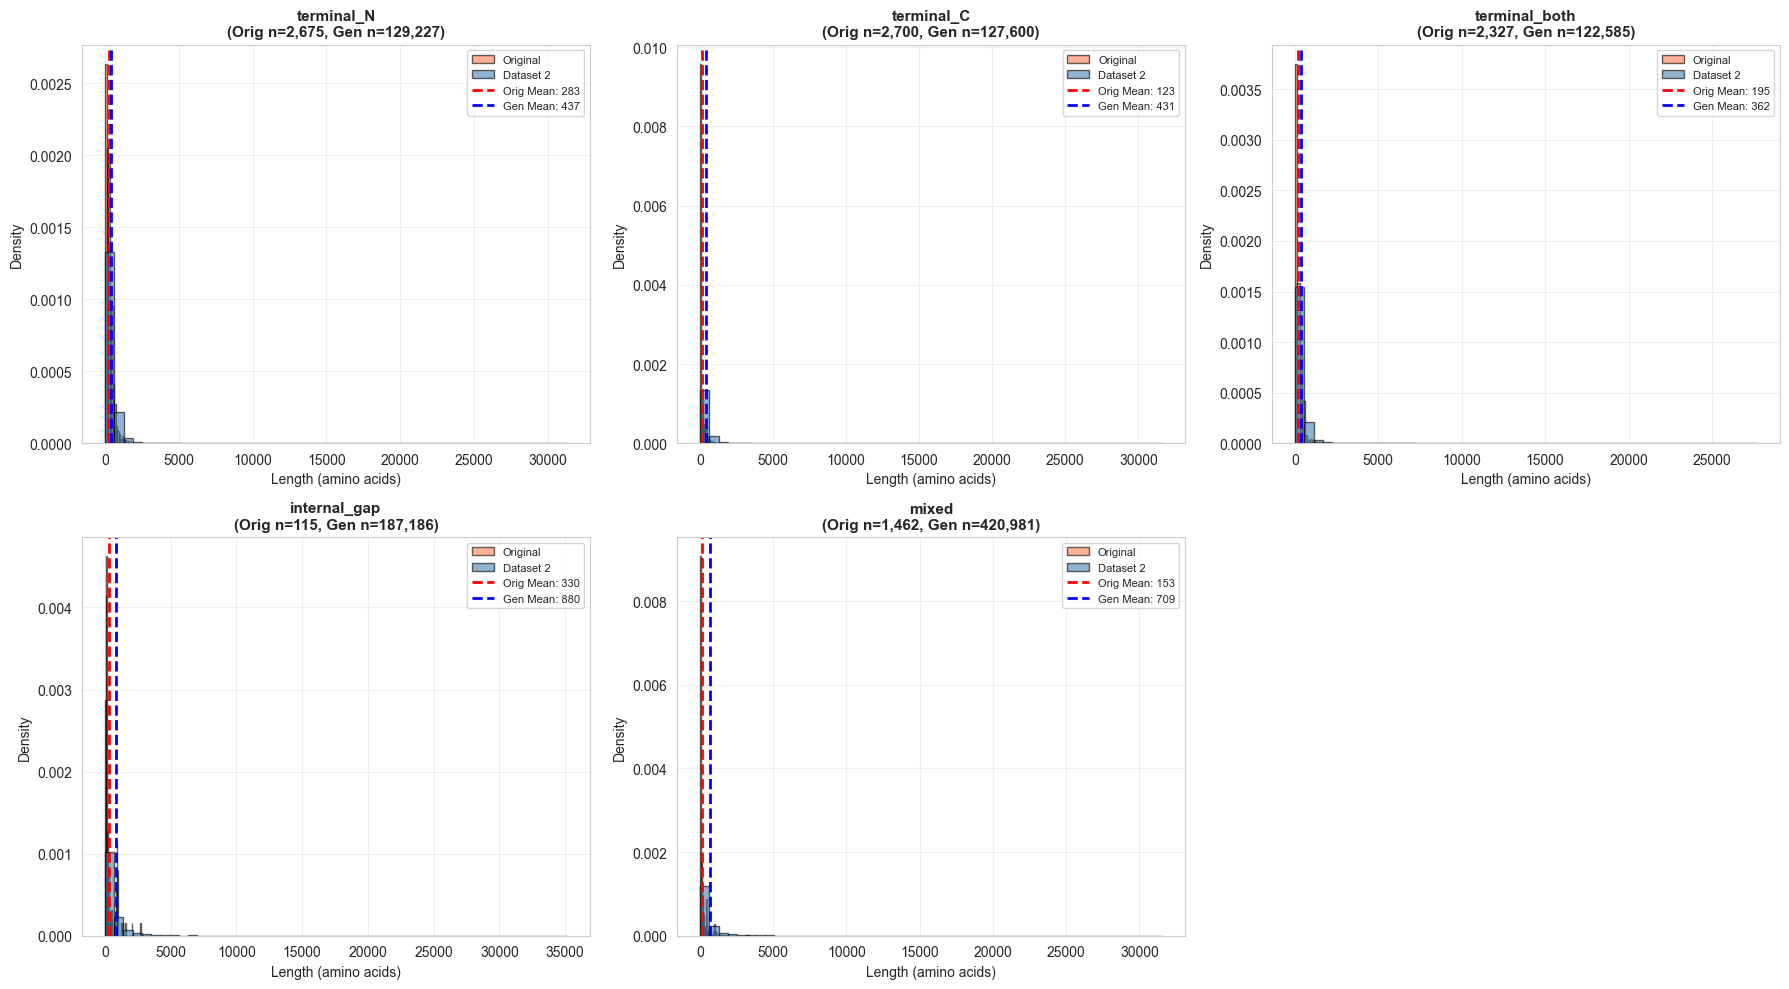


✓ Length distribution comparison plot saved to 'dataset2_length_comparison.png'


In [11]:
if has_original_data:
    # Plot length distributions: Original vs Generated (Dataset 2)
    fragment_types = ['terminal_N', 'terminal_C', 'terminal_both', 'internal_gap', 'mixed']
    n_types = len(fragment_types)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, ftype in enumerate(fragment_types):
        if ftype in original_stats and ftype in generated_stats:
            # Get data
            original_data = original_stats[ftype]['values']
            generated_data = generated_stats[ftype]['values']
            
            # Plot histograms
            axes[i].hist(original_data, bins=50, alpha=0.6, label='Original', 
                        color='coral', edgecolor='black', density=True)
            axes[i].hist(generated_data, bins=50, alpha=0.6, label='Dataset 2', 
                        color='steelblue', edgecolor='black', density=True)
            
            # Add mean lines
            axes[i].axvline(original_stats[ftype]['mean'], color='red', 
                          linestyle='--', linewidth=2, label=f'Orig Mean: {original_stats[ftype]["mean"]:.0f}')
            axes[i].axvline(generated_stats[ftype]['mean'], color='blue', 
                          linestyle='--', linewidth=2, label=f'Gen Mean: {generated_stats[ftype]["mean"]:.0f}')
            
            # Formatting
            axes[i].set_title(f'{ftype}\n(Orig n={len(original_data):,}, Gen n={len(generated_data):,})', 
                            fontweight='bold', fontsize=11)
            axes[i].set_xlabel('Length (amino acids)', fontsize=10)
            axes[i].set_ylabel('Density', fontsize=10)
            axes[i].legend(fontsize=8, loc='upper right')
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplot
    if n_types < len(axes):
        axes[n_types].axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset2_length_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Length distribution comparison plot saved to 'dataset2_length_comparison.png'")

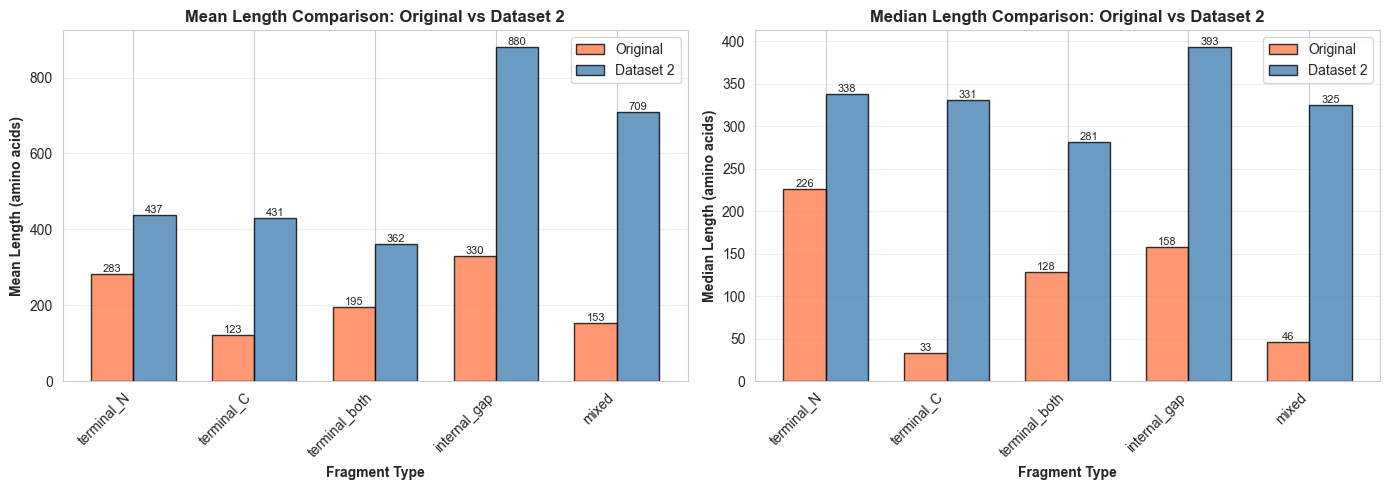

✓ Mean/Median comparison plot saved to 'dataset2_mean_median_comparison.png'


In [12]:
if has_original_data:
    # Create bar plot comparison of mean lengths
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    fragment_types = ['terminal_N', 'terminal_C', 'terminal_both', 'internal_gap', 'mixed']
    x = np.arange(len(fragment_types))
    width = 0.35
    
    original_means = [original_stats[ft]['mean'] for ft in fragment_types if ft in original_stats]
    generated_means = [generated_stats[ft]['mean'] for ft in fragment_types if ft in generated_stats]
    
    # Mean comparison
    bars1 = ax1.bar(x - width/2, original_means, width, label='Original', 
                    color='coral', edgecolor='black', alpha=0.8)
    bars2 = ax1.bar(x + width/2, generated_means, width, label='Dataset 2', 
                    color='steelblue', edgecolor='black', alpha=0.8)
    
    ax1.set_xlabel('Fragment Type', fontweight='bold')
    ax1.set_ylabel('Mean Length (amino acids)', fontweight='bold')
    ax1.set_title('Mean Length Comparison: Original vs Dataset 2', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(fragment_types, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=8)
    
    # Median comparison
    original_medians = [original_stats[ft]['median'] for ft in fragment_types if ft in original_stats]
    generated_medians = [generated_stats[ft]['median'] for ft in fragment_types if ft in generated_stats]
    
    bars3 = ax2.bar(x - width/2, original_medians, width, label='Original', 
                    color='coral', edgecolor='black', alpha=0.8)
    bars4 = ax2.bar(x + width/2, generated_medians, width, label='Dataset 2', 
                    color='steelblue', edgecolor='black', alpha=0.8)
    
    ax2.set_xlabel('Fragment Type', fontweight='bold')
    ax2.set_ylabel('Median Length (amino acids)', fontweight='bold')
    ax2.set_title('Median Length Comparison: Original vs Dataset 2', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(fragment_types, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('dataset2_mean_median_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Mean/Median comparison plot saved to 'dataset2_mean_median_comparison.png'")

## 9. Save Dataset 2

In [13]:
# Shuffle and save
dataset2_shuffled = dataset2.sample(frac=1, random_state=42).reset_index(drop=True)
output_file = 'dataset2_augmented_fragments.csv'
dataset2_shuffled.to_csv(output_file, index=False)

print(f"✓ Dataset 2 saved to '{output_file}'")
print(f"\nFinal Dataset 2 Summary:")
print("="*60)
print(f"Total sequences: {len(dataset2_shuffled):,}")
print(f"Fragments: {dataset2_shuffled['is_fragment'].sum():,}")
print(f"  - With synthetic cuts: {dataset2_shuffled[dataset2_shuffled['is_fragment']==1]['is_synthetic'].sum():,}")
print(f"  - Domain-based only: {(dataset2_shuffled['is_fragment']==1).sum() - dataset2_shuffled[dataset2_shuffled['is_fragment']==1]['is_synthetic'].sum():,}")
print(f"Complete: {(dataset2_shuffled['is_fragment'] == 0).sum():,}")

✓ Dataset 2 saved to 'dataset2_augmented_fragments.csv'

Final Dataset 2 Summary:
Total sequences: 1,975,158
Fragments: 987,579
  - With synthetic cuts: 764,735
  - Domain-based only: 222,844
Complete: 987,579


## 10. Summary

### Dataset 2 Characteristics:
- **Strategy**: Augment domain annotations with synthetic cuts
- **Key Feature**: Adds synthetic N/C-terminal cuts where natural domains are missing
- **Benefit**: Significantly increases `terminal_both` fragments
- **Tracking**: `is_synthetic` column indicates synthetic cuts

### Comparison with Dataset 1:
- More `terminal_both` fragments due to synthetic augmentation
- Same proteins, but more fragment diversity
- Mix of biological (domain-based) and synthetic cuts

### Next Step:
**Dataset 3**: Distribution-matched, fully synthetic, domain-agnostic random cuts